1. **Installing Required Packages**

In [1]:
pip install librosa numpy scipy matplotlib ipython tensorflow h5py seaborn pandas scikit-learn ipywidgets sounddevice wavio streamlit tensorflow-hub

Note: you may need to restart the kernel to use updated packages.


2. **Importing Libraries**

In [2]:
import os
import glob
import warnings
import pickle
import random
import numpy as np
import pandas as pd
import librosa
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import tensorflow_hub as hub
import ipywidgets as widgets
from IPython.display import Audio, display
from sklearn.utils import resample
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (Dense, Dropout)
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Suppress warnings
warnings.filterwarnings('ignore')
sns.set(style='whitegrid')

# Update TensorFlow configurations to avoid deprecation warnings
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

# Load YAMNet model from TensorFlow Hub
yamnet_model = hub.load('https://tfhub.dev/google/yamnet/1')

3. **Define Paths and Load Metadata**

In [3]:
home_directory = os.path.expanduser("~")
base_directory = os.path.join(home_directory, 'Desktop', 'sounds', 'UrbanSound8k')
csv_directory = os.path.join(base_directory, 'metadata', 'UrbanSound8K.csv')
audio_directory = os.path.join(base_directory, 'audio')

In [4]:
# Load the metadata from the CSV file
try:
    meta_df = pd.read_csv(csv_directory)
    print(f"Loaded metadata.")
except FileNotFoundError:
    print(f"File not found.")
except PermissionError:
    print(f"Permission denied when trying to read the file.")
except Exception as e:
    print(f"An error occurred while loading the CSV file: {e}")

# List all audio files in the directory
audio_files = glob.glob(os.path.join(audio_directory, '**', '*.wav'), recursive=True)

Loaded metadata.


b. *Visualizations*

i. Bar Plot and Pie Chart for Class Distribution

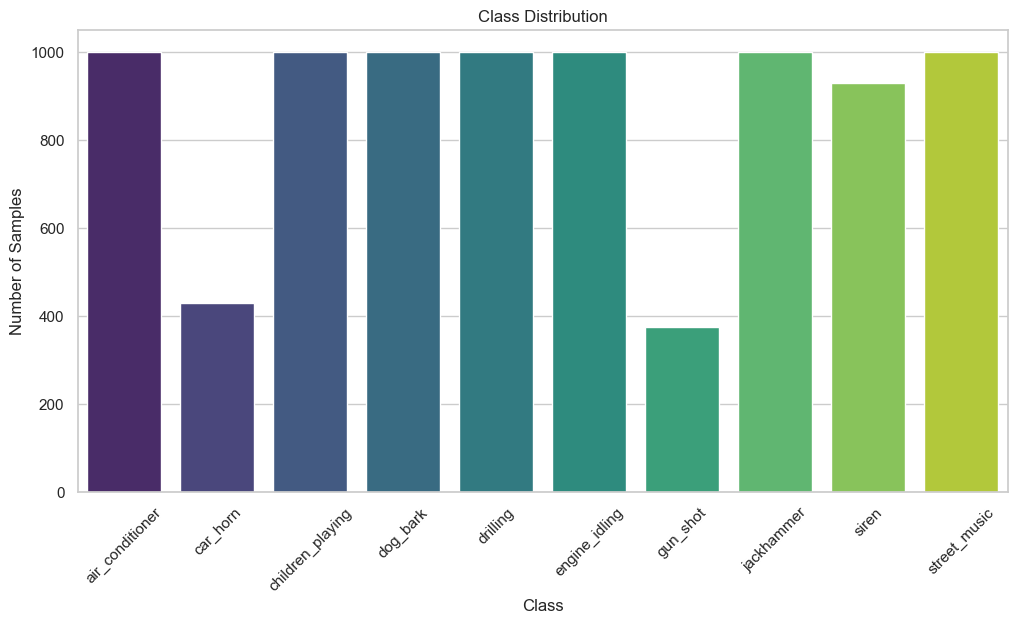

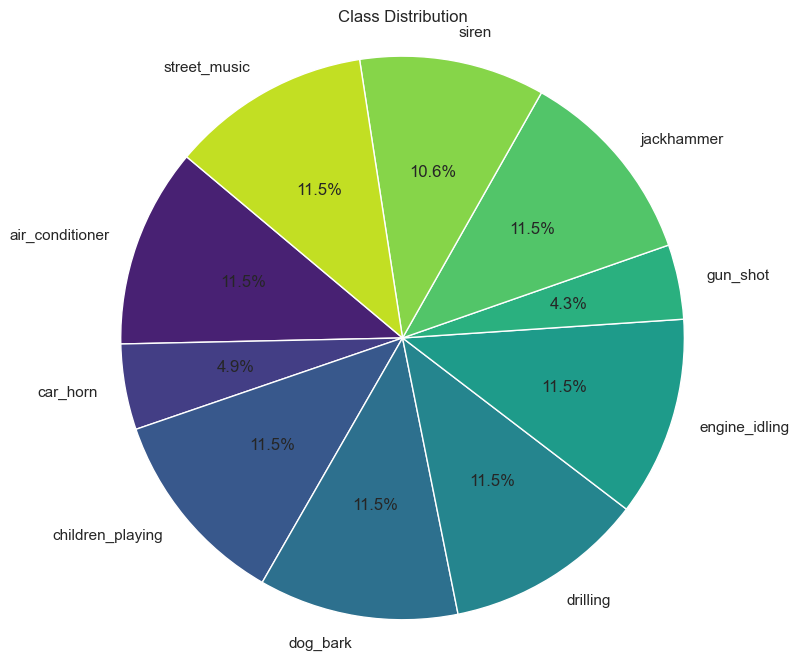

In [5]:
# Count of each class
class_counts = meta_df['class'].value_counts().sort_index()

# Bar Plot
plt.figure(figsize=(12, 6))
sns.barplot(x=class_counts.index, y=class_counts.values, palette='viridis')
plt.title('Class Distribution')
plt.xlabel('Class')
plt.ylabel('Number of Samples')
plt.xticks(rotation=45)
plt.show()

# Pie Chart
plt.figure(figsize=(8, 8))
plt.pie(class_counts.values, labels=class_counts.index, autopct='%1.1f%%', startangle=140, colors=sns.color_palette('viridis', len(class_counts)))
plt.title('Class Distribution')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()

ii. Histogram of Sound Event Durations

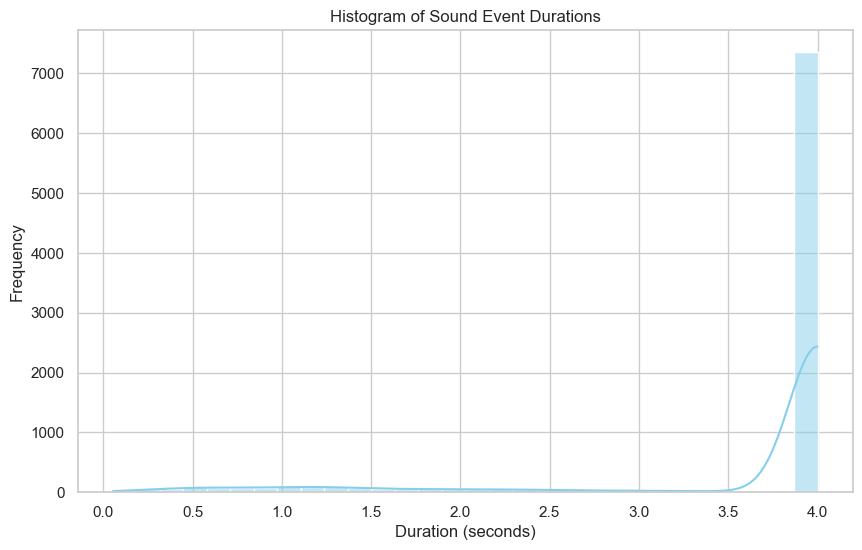

In [6]:
# Check if 'duration' column exists; if not, calculate it
if 'duration' not in meta_df.columns:
    # Duration in seconds can be calculated from start and end times if available
    if 'start' in meta_df.columns and 'end' in meta_df.columns:
        meta_df['duration'] = meta_df['end'] - meta_df['start']
    else:
        # As a fallback, use librosa to calculate duration from audio files
        def calculate_duration(file_path):
            try:
                y, sr = librosa.load(file_path, sr=None)
                return librosa.get_duration(y=y, sr=sr)
            except:
                return np.nan

        meta_df['duration'] = meta_df['file_name'].apply(lambda x: calculate_duration(os.path.join(audio_directory, f"fold{meta_df.loc[meta_df['file_name'] == x, 'fold'].values[0]}", x)))

# Drop NaN durations
duration_df = meta_df.dropna(subset=['duration'])

# Histogram
plt.figure(figsize=(10, 6))
sns.histplot(duration_df['duration'], bins=30, kde=True, color='skyblue')
plt.title('Histogram of Sound Event Durations')
plt.xlabel('Duration (seconds)')
plt.ylabel('Frequency')
plt.show()

iii. Correlation Matrix

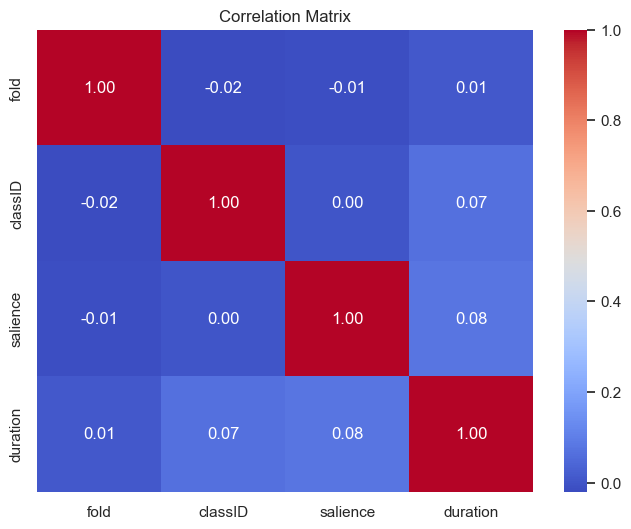

In [7]:
# Select numerical columns for correlation
numerical_cols = ['fold', 'classID', 'salience', 'duration'] if 'salience' in meta_df.columns else ['fold', 'classID', 'duration']

# Compute correlation matrix
corr_matrix = meta_df[numerical_cols].corr()

# Plot the correlation matrix
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix')
plt.show()

**Oversampling**

In [8]:
# Analyze class distribution
class_distribution = meta_df['class'].value_counts()
print("Class Distribution:\n", class_distribution)

Class Distribution:
 class
dog_bark            1000
children_playing    1000
air_conditioner     1000
street_music        1000
engine_idling       1000
jackhammer          1000
drilling            1000
siren                929
car_horn             429
gun_shot             374
Name: count, dtype: int64


In [9]:
# Create a balanced DataFrame
balanced_df = pd.DataFrame()

# Get the maximum number of samples among all classes
max_samples = class_distribution.max()

In [10]:
# Oversample each class to match the maximum
for cls in class_distribution.index:
    class_subset = meta_df[meta_df['class'] == cls]
    oversampled_subset = resample(class_subset, replace=True, n_samples=max_samples, random_state=42)
    balanced_df = pd.concat([balanced_df, oversampled_subset])

# Print the new class distribution after balancing
print("Balanced Class Distribution:\n", balanced_df['class'].value_counts())

Balanced Class Distribution:
 class
dog_bark            1000
children_playing    1000
air_conditioner     1000
street_music        1000
engine_idling       1000
jackhammer          1000
drilling            1000
siren               1000
car_horn            1000
gun_shot            1000
Name: count, dtype: int64


Saving balanced data

In [11]:
balanced_df.to_csv(os.path.join(base_directory, 'balanced_metadata.csv'), index=False)

4. **Matching Audio Files with Metadata**

In [12]:
# Rename 'slice_file_name' to 'file_name' for consistency
if 'slice_file_name' in balanced_df.columns:
    balanced_df.rename(columns={'slice_file_name': 'file_name'}, inplace=True)
else:
    print("The 'slice_file_name' column is missing from the metadata.")
    exit(1)

# Verify the renaming
print(balanced_df[['file_name', 'classID', 'class']].head())

# Ensure that all audio files have corresponding metadata entries
audio_file_names = [os.path.basename(f) for f in audio_files]
metadata_file_names = balanced_df['file_name'].unique()

missing_files = set(audio_file_names) - set(metadata_file_names)
if missing_files:
    print(f"Warning: {len(missing_files)} audio files do not have metadata entries.")

# Optionally, filter audio_files to include only those with metadata
audio_files = [f for f in audio_files if os.path.basename(f) in metadata_file_names]
print(f"Total audio files after filtering: {len(audio_files)}")

              file_name  classID     class
843   117048-3-0-25.wav        3  dog_bark
4947   194754-3-0-2.wav        3  dog_bark
7574    72537-3-0-2.wav        3  dog_bark
3037   164312-3-3-0.wav        3  dog_bark
847   117072-3-0-19.wav        3  dog_bark
Total audio files after filtering: 5623


5. **Audio File Visualization: Spectrogram, Waveform, and Audio Playback**

a. *Function to Plot Spectrogram and Waveform with Audio Playback*

In [13]:
def plot_waveform_and_spectrogram(file_path):
    try:
        y, sr = librosa.load(file_path, sr=None)
        plt.figure(figsize=(14, 6))

        # Waveform
        plt.subplot(1, 2, 1)
        librosa.display.waveshow(y, sr=sr, alpha=0.6)
        plt.title('Waveform')

        # Spectrogram
        plt.subplot(1, 2, 2)
        S = librosa.stft(y)
        S_DB = librosa.amplitude_to_db(np.abs(S), ref=np.max)
        librosa.display.specshow(S_DB, sr=sr, x_axis='time', y_axis='log', cmap='magma')
        plt.colorbar(format='%+2.0f dB')
        plt.title('Spectrogram')
        plt.tight_layout()
        plt.show()
        display(Audio(y, rate=sr))
    except Exception as e:
        print(f"Error processing {file_path}: {e}")

b. *Select and Visualize Random Audio Files*


Sample 1: 75743-0-0-0.wav


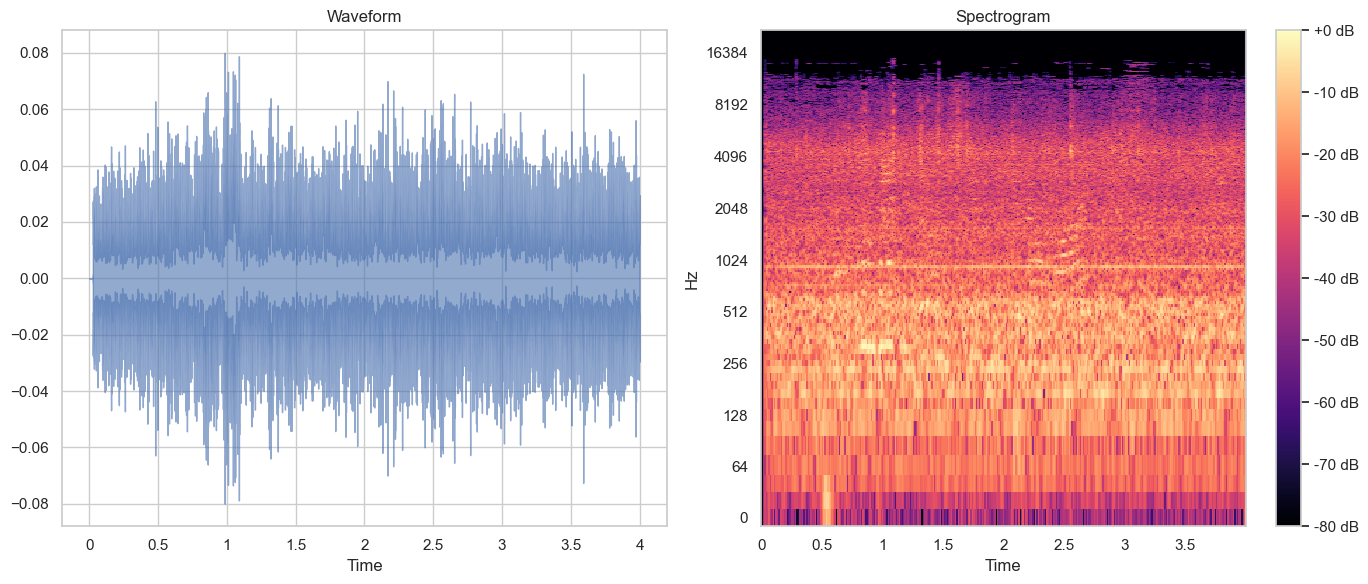


Sample 2: 135544-6-6-0.wav


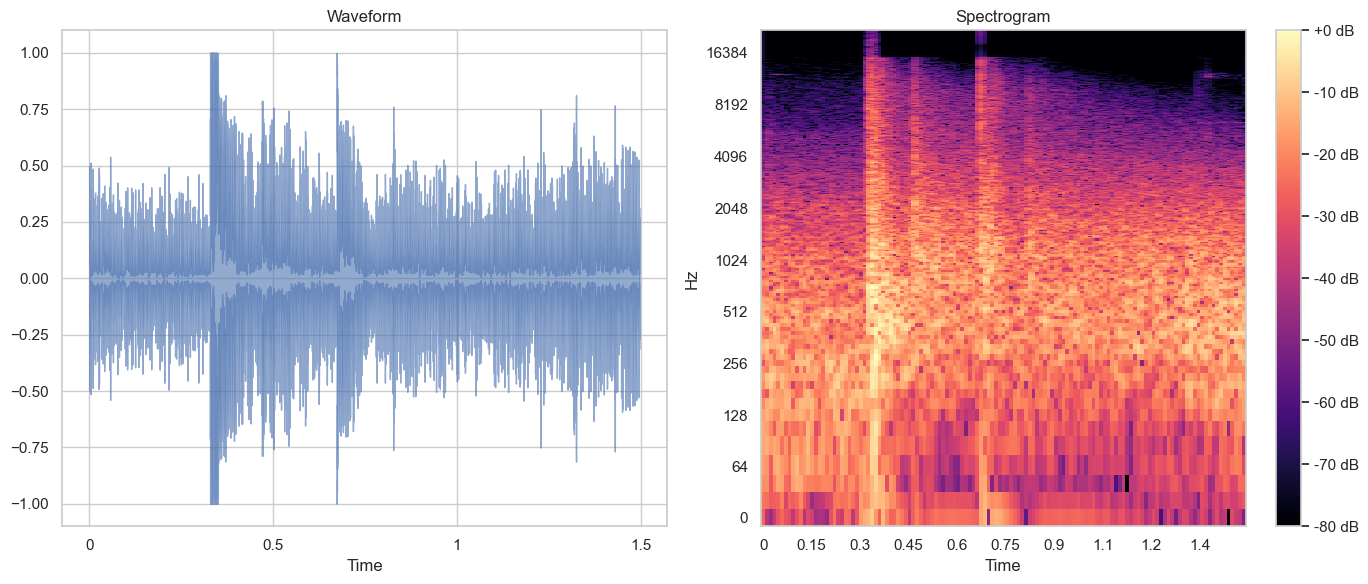


Sample 3: 30206-7-0-22.wav


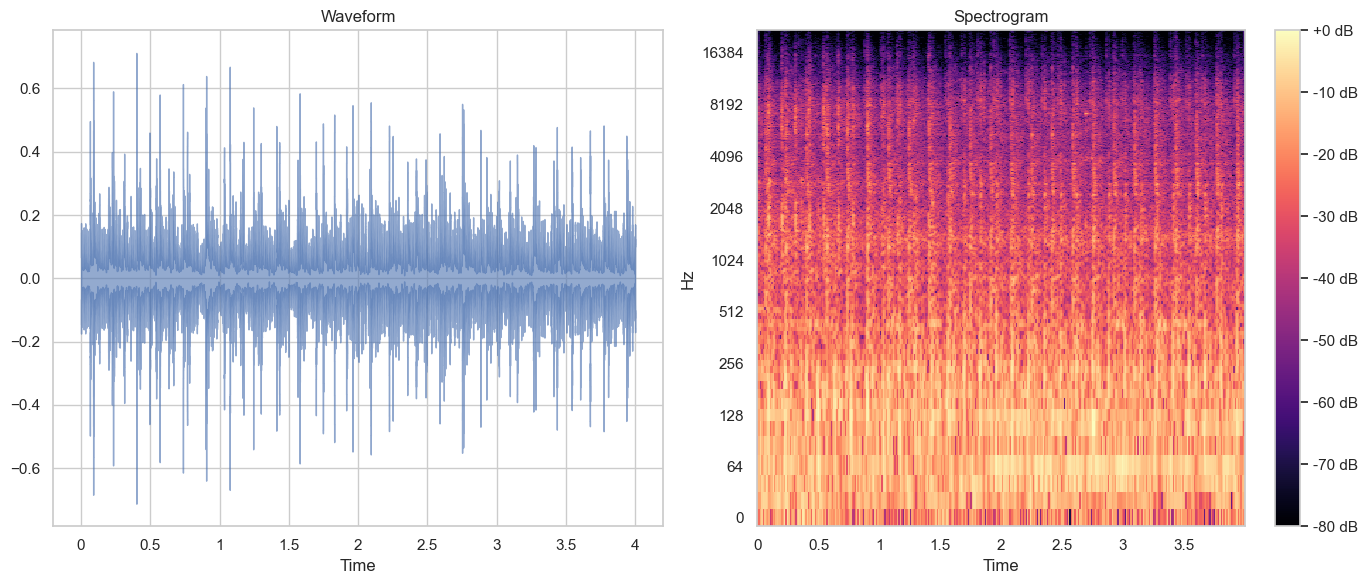

In [14]:
# Number of random files to visualize
num_samples = 3

# Select random audio files
random_audio_files = random.sample(audio_files, num_samples) if len(audio_files) >= num_samples else audio_files

for idx, file_path in enumerate(random_audio_files, 1):
    print(f"\nSample {idx}: {os.path.basename(file_path)}")
    plot_waveform_and_spectrogram(file_path)

6. **Feature Extraction**

In [15]:
def extract_yamnet_features(file_path):
    y, sr = librosa.load(file_path, sr=16000)
    waveform = tf.convert_to_tensor(y, dtype=tf.float32)
    _, yamnet_embeddings, _ = yamnet_model(waveform)
    return np.mean(yamnet_embeddings, axis=0)

In [16]:
def prepare_data(metadata, audio_base_dir):
    features, labels = [], []
    for _, row in metadata.iterrows():
        file_name, class_label, fold = row['file_name'], row['class'], row['fold']
        file_path = os.path.join(audio_base_dir, f'fold{fold}', file_name)
        if os.path.exists(file_path):
            feature = extract_yamnet_features(file_path)
            if feature is not None:
                features.append(feature)
                labels.append(class_label)
    return np.array(features), np.array(labels)

In [21]:
# Prepare the data using YAMNet
X, y = prepare_data(balanced_df, audio_directory)

7. **Data Preparation for Model Training**

In [22]:
le = LabelEncoder()
y_encoded = le.fit_transform(y)
num_classes = len(le.classes_)
y_categorical = to_categorical(y_encoded, num_classes=num_classes)

In [23]:
X_train, X_test, y_train, y_test = train_test_split(X, y_categorical, test_size=0.3, random_state=42, stratify=y_encoded)

8. **Model Creation**

In [24]:
def build_hybrid_cnn_rnn(input_shape, num_classes):
    model = Sequential()
    model.add(Dense(128, activation='relu', input_shape=input_shape))
    model.add(Dropout(0.3))
    model.add(Dense(num_classes, activation='softmax'))
    return model

In [25]:
input_shape = (X.shape[1],)

cnn_rnn_model = build_hybrid_cnn_rnn(input_shape, num_classes)
cnn_rnn_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
cnn_rnn_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               131200    
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 10)                1290      
                                                                 
Total params: 132,490
Trainable params: 132,490
Non-trainable params: 0
_________________________________________________________________


9. **Model Training**

In [26]:
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
checkpoint = ModelCheckpoint('best_hybrid_cnn_rnn_model.keras', monitor='val_loss', save_best_only=True, mode='min')

history_hybrid = cnn_rnn_model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=32,
    validation_data=(X_test, y_test),
    callbacks=[early_stop, checkpoint],
    verbose=1
)

Epoch 1/50
219/219 [==============================] - 2s 6ms/step - loss: 0.7481 - accuracy: 0.7820 - val_loss: 0.4085 - val_accuracy: 0.8643
Epoch 2/50
219/219 [==============================] - 1s 3ms/step - loss: 0.4316 - accuracy: 0.8637 - val_loss: 0.3313 - val_accuracy: 0.8917
Epoch 3/50
219/219 [==============================] - 1s 4ms/step - loss: 0.3491 - accuracy: 0.8947 - val_loss: 0.2928 - val_accuracy: 0.9110
Epoch 4/50
219/219 [==============================] - 1s 3ms/step - loss: 0.2935 - accuracy: 0.9087 - val_loss: 0.2742 - val_accuracy: 0.9137
Epoch 5/50
219/219 [==============================] - 1s 3ms/step - loss: 0.2629 - accuracy: 0.9183 - val_loss: 0.2459 - val_accuracy: 0.9260
Epoch 6/50
219/219 [==============================] - 1s 4ms/step - loss: 0.2313 - accuracy: 0.9290 - val_loss: 0.2415 - val_accuracy: 0.9270
Epoch 7/50
219/219 [==============================] - 1s 4ms/step - loss: 0.2124 - accuracy: 0.9344 - val_loss: 0.2109 - val_accuracy: 0.9323
Epoch 

10. **Model Evaluation**

a. *Evaluate Model Performance*

In [27]:
test_loss, test_acc = cnn_rnn_model.evaluate(X_test, y_test, verbose=0)
print(f'Test Accuracy: {test_acc:.2f}')
print(f'Test Loss: {test_loss:.2f}')

Test Accuracy: 0.98
Test Loss: 0.13


b. *Plot Training & Validation Accuracy and Loss*

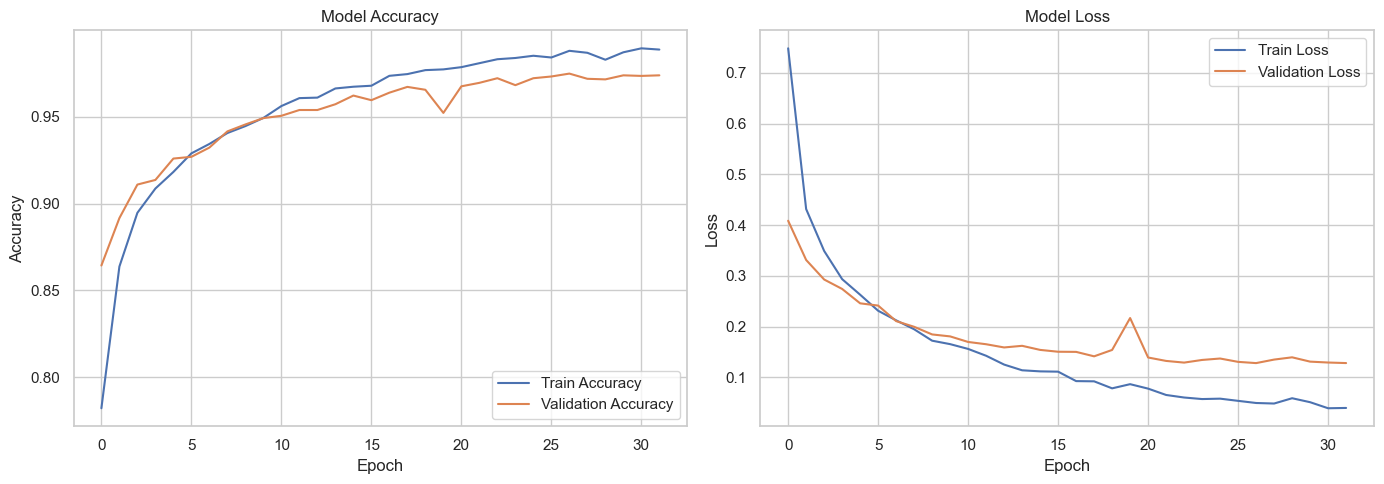

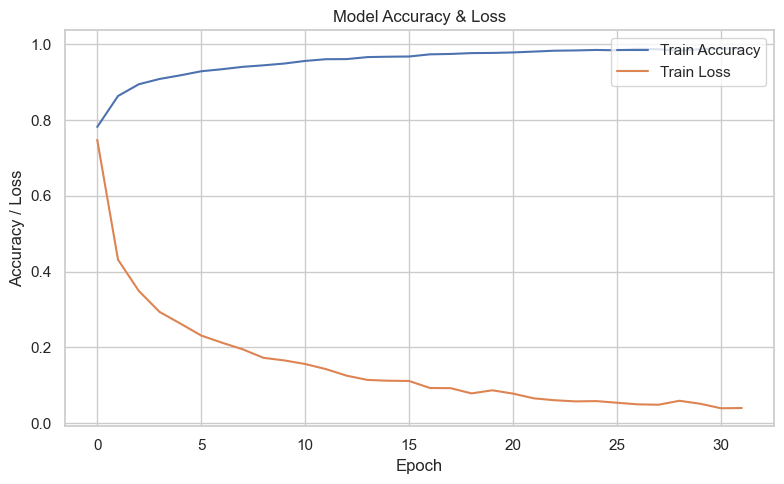

In [28]:
# Plot training & validation accuracy and loss values
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(history_hybrid.history['accuracy'], label='Train Accuracy')
plt.plot(history_hybrid.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='lower right')

plt.subplot(1, 2, 2)
plt.plot(history_hybrid.history['loss'], label='Train Loss')
plt.plot(history_hybrid.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')

plt.tight_layout()
plt.show()

# Plot accuracy and loss together on its own plot
plt.figure(figsize=(8, 5))
plt.plot(history_hybrid.history['accuracy'], label='Train Accuracy')
plt.plot(history_hybrid.history['loss'], label='Train Loss')
plt.title('Model Accuracy & Loss')
plt.ylabel('Accuracy / Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')

plt.tight_layout()
plt.show()

c. Generate Predictions and Sample Comparisons

In [29]:
# Calculate and print percentage distribution of predictions
y_pred = cnn_rnn_model.predict(X_test)
percentage_distribution = np.mean(y_pred, axis=0)

print("\nPercentage Distribution of Predictions:")
for i, class_name in enumerate(le.classes_):
    print(f"{class_name}: {percentage_distribution[i]*100:.2f}%")

94/94 [==============================] - 0s 2ms/step

Percentage Distribution of Predictions:
air_conditioner: 9.64%
car_horn: 10.13%
children_playing: 10.08%
dog_bark: 10.22%
drilling: 9.97%
engine_idling: 9.90%
gun_shot: 10.06%
jackhammer: 10.11%
siren: 9.96%
street_music: 9.94%


d. Confusion Matrix

In [ ]:
# Confusion Matrix
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

cm = confusion_matrix(y_true, y_pred_classes)

class_names = le.classes_
cm_df = pd.DataFrame(cm, index=class_names, columns=class_names)

plt.figure(figsize=(12, 10))
sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('True Class')
plt.xlabel('Predicted Class')
plt.tight_layout()
plt.show()

NameError: name 'np' is not defined

e. Classification Report

In [31]:
# Classification Report
report = classification_report(y_true, y_pred_classes, target_names=class_names)
print("Classification Report:\n")
print(report)

Classification Report:

                  precision    recall  f1-score   support

 air_conditioner       0.98      0.95      0.96       300
        car_horn       0.98      0.98      0.98       300
children_playing       0.96      0.97      0.97       300
        dog_bark       0.97      0.97      0.97       300
        drilling       0.98      0.97      0.97       300
   engine_idling       0.98      0.98      0.98       300
        gun_shot       0.99      1.00      1.00       300
      jackhammer       0.97      0.99      0.98       300
           siren       0.99      0.99      0.99       300
    street_music       0.95      0.95      0.95       300

        accuracy                           0.97      3000
       macro avg       0.98      0.97      0.97      3000
    weighted avg       0.98      0.97      0.97      3000



11. **Saving the Model and Label Encoder**

a. *Organizing Saved Files*

In [32]:
# Ensure directories for saving the model and encoder exist using TensorFlow I/O
tf.io.gfile.makedirs('saved_models')
tf.io.gfile.makedirs('saved_encoders')

b. *Save the model*

In [33]:
# Save the model in the SavedModel format
cnn_rnn_model.save('saved_models/hybrid_yamnet.keras')
cnn_rnn_model.save('saved_models/hybrid_yamnet.h5')
print("Model saved in .keras and .h5 format.")

Model saved in .keras and .h5 format.


c. *Save the LabelEncoder*

In [34]:
# Save the LabelEncoder using pickle in the 'saved_encoders' directory
with open('saved_encoders/ylabel_e.pkl', 'wb') as le_file:
    pickle.dump(le, le_file)
print("LabelEncoder saved as 'saved_encoders/ylabel_e.pkl'.")

LabelEncoder saved as 'saved_encoders/ylabel_e.pkl'.


d. *Verifying the Saved Model and Label Encoder*

In [35]:
# Load the saved CNN model
loaded_cnn_model = tf.keras.models.load_model('saved_models/hybrid_yamnet.h5')
print("Loaded CNN-RNN model from 'saved_models/hybrid_yamnet.h5'.")

# Load the saved LabelEncoder
with open('saved_encoders/ylabel_e.pkl', 'rb') as le_file:
    loaded_le = pickle.load(le_file)
print("Loaded LabelEncoder from 'saved_encoders/ylabel_e.pkl'.")

Loaded CNN-RNN model from 'saved_models/hybrid_yamnet.h5'.
Loaded LabelEncoder from 'saved_encoders/ylabel_e.pkl'.


e. *Testing The Model And Encoder*

In [36]:
# Testing the loaded model with a sample from the test set
sample_index = 0  # Modify the index as needed

# Ensure sample_index is within bounds
if sample_index >= len(X_test):
    print(f"Sample index {sample_index} is out of bounds for X_test with length {len(X_test)}.")
else:
    sample_features = X_test[sample_index].reshape(1, -1)  # Reshape to match model input shape
    sample_true_label = y_test[sample_index]

    # Verify the shape of sample_true_label
    print(f"sample_true_label shape: {sample_true_label.shape}")  # Should match the number of classes

    # Predict using the loaded model
    sample_pred = loaded_cnn_model.predict(sample_features)
    sample_pred_class = np.argmax(sample_pred, axis=1)  # Shape: (1,)

    # Decode the labels
    sample_true_class = np.argmax(sample_true_label)
    predicted_label = loaded_le.inverse_transform(sample_pred_class)[0]
    true_label = loaded_le.inverse_transform([sample_true_class])[0]

    print(f"Predicted Label: {predicted_label}")
    print(f"True Label: {true_label}")

sample_true_label shape: (10,)
1/1 [==============================] - 0s 45ms/step
Predicted Label: car_horn
True Label: car_horn
